In [1]:
from numba import jit

from matplotlib import pyplot as plt
from IPython.display import clear_output

from datetime import datetime

import os

from io import StringIO
import time
import pandas as pd
import os
import numpy as np

#@jit(nopython=True)
#generate an uniform unit vector
def spin_gen():
    coord = [np.random.normal() for i in range(3)]
    r = np.sqrt(sum(x*x for x in coord))
    v = [x/r for x in coord]
    return v


#@jit(nopython=True)
def system_gen(dim = 2, r = False):
    '''Generate a 3D cubic lattice of spins.
    > dim = (nx,ny,nz) --> number of spins for each axis of the lattice
    > r   --> select how to initialize the lattice of spins: 
                True = all randomly oriented
                False = all oriented along the z direction
    < orientation --> dim**3 dimensional lattice of spin coordinates 
                      of the form [i,j,k,[x,y,z]]:
                        i --> x axis of the lattice
                        j --> y axis of the lattice
                        k --> z axis of the lattice
                        [x,y,z] --> components of the spin in the lattice reference system
    '''
    
    #generate a lattice of spins randomly oriented
    if r == True:
        orientation = [ [ [ spin_gen() for k in range(-1,dim+1)] for j in range(-1,dim+1)] for i in range(-1,dim+1) ]
        orientation = np.array(orientation)

    #generate a set of spins oriented along the z direction
    else:
        orientation = [ [ [ [0.,0.,1.] for k in range(-1,dim+1)] for j in range(-1,dim+1)] for i in range(-1,dim+1) ]
        orientation = np.array(orientation)

        
    #Populate periodic boundary sites
    orientation = make_periodic_boundaries(orientation)
       
    return orientation


#Population of boundaries
def make_periodic_boundaries(input_system):
    '''sys shoud be the full matrix with already the available sites for periodic boundary condition'''
    
    #number of ACTUAL SPINS per site. 
    #Periodic condition implies 1 fictitious site at the beginning and the end of the dimention --> -2
    dim = np.shape(input_system)[0]-2

    #Periodic boundary condition
    input_system[dim+1,:,:,:] = input_system[1,:,:,:]
    input_system[0,:,:,:] = input_system[dim,:,:,:]
    input_system[:,dim+1,:,:] = input_system[:,1,:,:]
    input_system[:,0,:,:] = input_system[:,dim,:,:]
    input_system[:,:,dim+1,:] = input_system[:,:,1,:]
    input_system[:,:,0,:] = input_system[:,:,dim,:]

    
    return input_system

    

@jit(nopython=True)
def calc_S(input_system):
    '''Calculation of the scalar order paramenter S
        
        > input_system = [i,j,k, spin_components = [x,y,z]]
        < S --> scalar oder parameter
    '''
    
    # get the number of spins along one axis
    #  Cubic lattice has been assumed
    dim = np.shape(input_system)[0]-2
    
    
    # initialize the tensor Q with all 0s
    Q = np.zeros((3,3))
    
    #will act as a kroneker delta
    I = np.identity(3)
    
    for i in range(3):
        for j in range(3):

            #note: the factor 3 and the kroneker delta have been brought out the sum
            # dim+1 because high is escluded
            Q[i,j] = (1/(2*dim**3)) * (3* np.sum( np.ravel(input_system[1:dim+1,1:dim+1,1:dim+1,i]*input_system[1:dim+1,1:dim+1,1:dim+1,j])  ) - I[i,j]*dim**3)
    
    #Calculation eigen(val&vect) of the order tensor Q
    #    [w = eigenvalues, v = eigenvectors]
    w, v = np.linalg.eig(Q)
    
    #maximum eigenvalue
    S = max(w)
    
    return S



@jit(nopython=True)
def bin_selection_v3_no_min(S_val ,step):
    
    #extraction of the index
    bin_index = abs(S_val-S_min)/step
    bin_index =int(bin_index)
    
    
    return bin_index



#Evaluate Omega
@jit(nopython=True)
def update_omega(input_omega_bins, bin_index, ln_f):
    
    #Here I can use slicing because I'm not really interested in making a copy
    output_omega_bins = input_omega_bins[:]
    
    #update omega
    #note: "+f because we are dealing with ln(f)"
    output_omega_bins[bin_index] =  output_omega_bins[bin_index] + ln_f
    
    return output_omega_bins



#Evaluate flatness -- << Put an error check: (0/0) try <<
#@jit(nopython=True)
def flatness_calc(hist, S_min, S_max, step):
    
    #Calculate the indexes of the hist region where flatness must be evaluated
    #index_S_min = int( S_min/step )
    #index_S_max = int( (0.6-S_min)/step )
    
    #extract max and min from hist
    #max_hist = max( hist[index_S_min:index_S_max] )
    #min_hist = min( hist[index_S_min:index_S_max] )
    max_hist = max( hist[:] )
    min_hist = min( hist[:] )
    
    #note: if all 0 you can't make the division (0/0). Should make an error message
    #may happen if the intervall you are calculating flatness is too small
    if max_hist == 0:
        flatness = 0
        print('!! max_hist = 0')
        return flatness
        
    #Evaluate flattnes: 
    # flatness = 0 --> there are zeros in the array or flatness is very bad
    # flatness = 1 --> histogram plot is flat
    flatness = 1 - ( max_hist - min_hist ) / ( max_hist + min_hist )
    
    
    
    return flatness


#Evaluation of the energy contribute between two spins
@jit(nopython=True)
def LL_energy_contribute(a,b):
    '''a, b are the two vectors for which the energetic contribute must be calculated'''
    
    #extract the magnitude of each vector. Should be already 1
    #norm_a = np.linalg.norm(a) #1 by construction
    #norm_b = np.linalg.norm(b)
    
    #calculate the angle between the two vectors
    cos_alpha =  np.dot(a,b)  
    
    #evaluation of the energy contribute
    #note: we considered energy constant equal to 1
    h = - 0.5 * ( 3. * (cos_alpha)**2 - 1. )
    
    return h


@jit(nopython=True)
def LL_energy_tot(input_system):

    # get the number of spins along one axis
    #  Cubic lattice has been assumed
    dim = input_system.shape[0]-2
    
    # initializzation of the sum for the energy
    H = 0
    
    #note: dim+1 because range do not include high
    for i in range(1,dim+1):
        for j in range(1,dim+1):
            for k in range(1,dim+1):
                
                #interaction with top spin
                H = H + LL_energy_contribute( input_system[i,j,k,:],input_system[i,j,k+1,:] )
                #interaction with bottom spin
                H = H + LL_energy_contribute( input_system[i,j,k,:],input_system[i,j,k-1,:] )
                
                #interaction with front spin
                H = H + LL_energy_contribute( input_system[i,j,k,:],input_system[i,j+1,k,:] )
                #interaction with back spin
                H = H + LL_energy_contribute( input_system[i,j,k,:],input_system[i,j-1,k,:] )
                
                #interaction with spin on the right
                H = H + LL_energy_contribute( input_system[i,j,k,:],input_system[i+1,j,k,:] )
                #interaction with spin on the left
                H = H + LL_energy_contribute( input_system[i,j,k,:],input_system[i-1,j,k,:] )
                
    #because each spin interaction is counted twice, even at the boundary
    H = H/2. 
           
    #Energy per spin
    U = H / dim**3
    
    return H


@jit(nopython=True)
def energy_per_site(input_system, spin_index):
    
    i= spin_index[0]
    j= spin_index[1]
    k= spin_index[2]
    
    E=0
    E = E + LL_energy_contribute(input_system[i,j,k,:],input_system[i+1,j,k,:])
    E = E + LL_energy_contribute(input_system[i,j,k,:],input_system[i-1,j,k,:])
    E = E + LL_energy_contribute(input_system[i,j,k,:],input_system[i,j+1,k,:])
    E = E + LL_energy_contribute(input_system[i,j,k,:],input_system[i,j-1,k,:])
    E = E + LL_energy_contribute(input_system[i,j,k,:],input_system[i,j,k+1,:])
    E = E + LL_energy_contribute(input_system[i,j,k,:],input_system[i,j,k-1,:])
    
    return E
   


@jit(nopython=True)
def acc_test(old_system, new_system, ln_omega_old, ln_omega_new, beta, spin_index,E_old):
    '''Decides whether to accept or reject a trial state'''
    
    U_site_old = energy_per_site(old_system, spin_index)
    U_site_new = energy_per_site(new_system, spin_index)
    
    E_new = E_old - U_site_old + U_site_new

    acc_val = np.random.uniform(0.,1.)    
    
    #evaluation of the acceptation parameter as a function of ln()
    ln_acc_param = ln_omega_old - ln_omega_new - ( beta*(E_new-E_old) )
    
    #>Debug
    #print(ln_acc_param, ln_omega_old, ln_omega_new, E_new, E_old,':::', U_site_old, U_site_new  )
    
    #reconversion of the acceptation parameter
    acc_param = np.exp(ln_acc_param)
    
    if acc_param == np.Inf:
        print('>> Err_Inf', ln_omega_old, ln_omega_new, E_new-E_old )
    
    #decide whether to accept or reject the state
    if (  acc_val <= min( 1. , acc_param )  ):
        
        #accept the new state
        accept_state = True
        
    else:
        
        #reject the state
        accept_state = False
    

    
#>> Debug <<   
    #print('U_new - U_old: ' , U_new - U_old)
    #print('ln_om - ln_om: ' , (ln_omega_old - ln_omega_new))
    #print('exp part: ' , -beta*(U_new - U_old) ) 
    #print('test : ' , acc_val ,'<', acc_param )

    #p = str([ln_omega_old, ln_omega_new, U_new-U_old])
    
    return accept_state, E_new #, p



#Calculation of steps
@jit(nopython=True)
def N_MC_cycles(ln_f_init, ln_f_fin, mul = 0.5):
    
    i=0
    ln_f = ln_f_init 
    while(ln_f >= ln_f_fin):
        ln_f = ln_f * mul
        i += 1
        
    return i


# -----------------------------------------------------------------------------

In [2]:
#Rewighting

#Argument are contracted 
#by not passing constants, they are taken as global variables
def rew_Init_tools():
    
    #Calculate number of betas reweighting must be performed for
    beta_rows = int( abs(T_min - T_max)/T_step )
    
    
    #Create matrix - Init to 0
    
    #For probability density
    ReW = np.array( [[ 0.0 for j in range(N_bin_S)] for i in range(beta_rows)] )
    #For internal energy average - <U>
    ReU = np.array( [[ 0.0 for j in range(N_bin_S)] for i in range(beta_rows)] )
    #For squared internal energy average - <U^2>
    ReU_2 = np.array( [[ 0.0 for j in range(N_bin_S)] for i in range(beta_rows)] )
    #Stores the total entry number for each S bin
    Ns = np.array( [0 for i in range(N_bin_S)] )
    #Array of all betas for which reweighting is performed
    rew_Ts = np.array([(T_min + T_step*i) for i in range(beta_rows)])
    betas = np.array( [1./rew_Ts[i] for i in range(beta_rows)] )
    
    
    return ReW, ReU, ReU_2, Ns, beta_rows, betas, rew_Ts



#Controlla bene chi passi come bin index...
@jit(nopython=True)
def rew_update(ReW, ReU, ReU_2, Ns, bin_index, U):
    
    for i in range(beta_rows):
        
        #Evaluating reweighting constant
        amp = np.exp(( beta - betas[i])* U)
        
        #Updating Matrixes
        ReW[i, bin_index] += amp
        ReU[i, bin_index] += amp*U
        ReU_2[i, bin_index] += amp*U**2
    
    #Incrementing entry for the S bin
    Ns[bin_index] += 1
    
    return ReW, ReU, ReU_2, Ns   


def rew_calc(ReW, ReU, ReU_2, Ns, S_values):
    
    #Init averages matrixes - one for each reweighted beta 
    av_U = np.zeros(beta_rows)
    av_U_2 = np.zeros(beta_rows)
    av_S = np.zeros(beta_rows)
    av_S_2 = np.zeros(beta_rows)
    #Partition function
    Z = np.zeros(beta_rows)
    #reweighted probability density
    rew_betaF =np.zeros( (beta_rows, N_bin_S) )
    
    for i in range(beta_rows):
        Z[i] = np.sum( np.exp(-betaF[:]) * ReW[i,:]/Ns[:] )
        rew_betaF[i,:] = - np.log( np.exp(-betaF[:])* (ReW[i,:]/Ns[:])/ Z[i] )
        av_U[i] = sum( np.exp(-betaF[:])* (ReU[i,:]/Ns[:]) ) / Z[i]
        av_U_2[i] = sum( np.exp(-betaF[:])* (ReU_2[i,:]/Ns[:]) ) / Z[i]
        av_S[i] = sum( np.exp(-rew_betaF[i,:])*S_values[:] )
        av_S_2[i] = sum( np.exp(-rew_betaF[i,:])*S_values[:]**2 )
    
    
    return rew_betaF, av_U, av_U_2, av_S, av_S_2

In [3]:
#@jit(nopython=True)
def spin_gen_quat( old_spin, intensity ):
    
    
    w = 1. -  (2.*np.random.rand(1)) * intensity
    v = 2. * np.random.rand(3) - 1.
    norm = np.linalg.norm(v)
    v = v / norm * np.sqrt( 1. - w**2 )
  
    #initializzation rotation matrix
    rot_mat = np.zeros((3,3))
  
    rot_mat[0,0] = 1. - 2.*v[1]**2 - 2.*v[2]**2
    rot_mat[0,1] = 2.*v[0]*v[1] + 2.*w*v[2]
    rot_mat[0,2] = 2.*v[0]*v[2] - 2.*w*v[1]
  
    rot_mat[1,0] = 2.*v[0]*v[1] - 2.*w*v[2]
    rot_mat[1,1] = 1. - 2.*v[0]**2 - 2.*v[2]**2
    rot_mat[1,2] = 2.*v[1]*v[2] + 2.*w*v[0]
  
    rot_mat[2,0] = 2.*v[0]*v[2] + 2.*w*v[1]
    rot_mat[2,1] = 2.*v[1]*v[2] - 2.*w*v[0]
    rot_mat[2,2] = 1. - 2.*v[0]**2 - 2.*v[1]**2
  
    new_spin = np.dot( rot_mat, old_spin )
    new_spin /=  np.linalg.norm(new_spin) 

    return new_spin


#Change a spin orientation in the lattice at random
#@jit(nopython=True)
def make_trial_quat(input_system, intensity):
    '''outputs a new sistem ewual to the input for exeption of the orientation of one spin'''
    
    #extrapolate number of lattice points per axis.
    #  Cubic lattice has been assumed
    dim = input_system.shape[0]-2
    
    #clone input system into output system
    output_system = input_system.copy()
    
    #select a random spin in the lattice [low] ]high[
    #Random coord generation
    spin_index = [ np.random.randint(1,dim+1) for i in range(3)]
    #print(spin_index)
    
    #>>generate a randomly oriented spin
    new_spin = spin_gen_quat(output_system[spin_index[0],spin_index[1],spin_index[2],:], intensity)
    
    #Updata boundaries
    
    #update the system with the new spin in the place of the corresponding old one
    output_system[spin_index[0],spin_index[1],spin_index[2],:] = new_spin[:].copy()
    
    #Update boundaries
    output_system = make_periodic_boundaries(output_system)
    
    
    return output_system, spin_index 

# Output management

In [4]:
def create_all_files():
    
    #Create the "data" directory. If it already exist, nothing happens
    try:
        os.makedirs("data")
    except:
        #print("This directory already exist, run the rest. Skip this cell for future runs")
        pass

    
    #so as to give a unique name to file and folders for each run
    timestr = get_timestr()
    
    file_path = create_the_directory(timestr, path = "data/")
    
    #all the text file created
    names = [ 'input_file', 'all_omega', 'all_hist', 'RESULTS', 'log_file']
    
    full_names = []
    
    #actual creation of the files
    for file_name in names:
        file_name += '____'
        full_file_name = make_txt_file(file_name, timestr, file_path)
        full_names.append(full_file_name)
    
    #log = 'file creati'
    print('file creati')
    
    #list of relative paths
    return full_names, file_path, timestr



#>> Ingredients

def get_timestr():
    '''creates a unique string using time library'''
    #get date to append it to the end of the file
    timestr = time.strftime( "%Y%m%d_%H%M%S" )
    
    return timestr


def create_the_directory(timestr, path = "dati/"):
    
    '''create a directory using timestring'''
    
    path += timestr
    
    try:
        #try to create the directory
        os.mkdir(path)
    except OSError:
        log = "Creation of the directory %s failed" % path
    else:
        log = "Successfully created the directory %s " % path
    
    path += '/' 
    
    return path



def make_txt_file(file_name, timestr, path = 'dati/'):
    
    '''create a text file'''
    
    #Creation of the filename
    full_file_name = path + file_name + '_' + timestr + '.txt'
    
    #Create a mew file. Return an error if the file already exist
    f = open(full_file_name, 'x')
    
    f.close()
    
    log = file_name + ' correctly created.\n'
    
    return full_file_name



#-------------------------------------------------------------------
#These function handles history of omega and histograms

#Append ana array to a file
def append_array_history(file_name, array):
    
    #Open the file in append mode. 
    #file_name --> is the full file name with extension 
    f = open(file_name, "a")
    
    #append the array to the file
    np.savetxt(f, array,  delimiter = ',')
    
    f.close()
    
    log = 'array saved in: >> ' + file_name + ' <<'
    
    return log


#Read arrays from a file
def read_array_history(file_name, index):
        
    #open the target file in read mode
    f = open(file_name, "r")
    
    #What you are passing is the index of the loop for to extract the line numer
    #But here what you need is the line number, so you have to sum 1 to compensate the 0 starting index
    line_number = index +1
  
    #read line by line until you reach the line you are interested in
    for i in range(line_number):
        data = StringIO(f.readline())
    
    #convert what you extract from the file into an array
    array = np.loadtxt(data, delimiter=',')
    
    return array



#-----------------------------------------
#Creation of a file that contains the final omega and hist
#fist column is final_omega the second final_hist

#Crete the file containing final omega and finalhist
def write_results(file_name, omega, hist):
    
    input_data = {'OmegaF': omega,
                 'HistF': hist}
    
    #creation of the DataFram, the object pandas can deal with
    df = pd.DataFrame(input_data, columns = ['OmegaF', 'HistF'])
    
    #store the dataframe in the file
    df.to_csv(file_name, index=False)
    
    #Log message of the operation
    log = 'result file correctly written'
    
    return log


def write_rew(file_name, rew_betaF):
    
    
    file_name = this_path + file_name + '.txt'
    
    rew_betaF_names = ['rew_betaF_T{:d}'.format(i) for i in range(len(betas))]
    
    input_data = {}
    
    #add to the dictionary the column of the rew_betaF trace of the corresponding beta
    for i in range(len(betas)):
        input_data[rew_betaF_names[i]] = rew_betaF[i,:]

    #creation of the DataFram, the object pandas can deal with
    df = pd.DataFrame(input_data, columns = rew_betaF_names)
    
    #store the dataframe in the file
    df.to_csv(file_name, index=False)

    #Log message of the operation
    log = 'rew_betaF file correctly written'
    
    return log
        
        
def write_ThermoProp(file_name, rew_Ts, Cv, Xs):


    file_name = this_path + file_name + '.txt'

    #Used to easily create a legend
    temps_name = ['T= {:.4f}'.format(rew_Ts[i]) for i in range(len(rew_Ts))]    
        
    input_data = {'rew_Ts': rew_Ts,
                  'Cv': Cv,
                  'Xs': Xs, 
                  'T_names': temps_name}
        
    #creation of the DataFram, the object pandas can deal with
    df = pd.DataFrame(input_data, columns = ['rew_Ts', 'Cv', 'Xs', 'T_names'])
    
    #store the dataframe in the file
    df.to_csv(file_name, index=False)


    #Log message of the operation
    log = 'Thermo. Prop. file correctly written'
    
    return log



#Read the file containig final omega and final hist
def read_reasults(file_name):
    
    file_name = this_path + file_name + '_____' + timestr + '.txt'
    
    #Interpret DataFile
    file = pd.read_csv(filepath_or_buffer = file_name, delimiter = ',', header=0)
    
    #Extract arrays
    final_omega = np.array(file.OmegaF.to_list())
    final_hist = np.array(file.HistF.to_list())
    
    return final_omega, final_hist

#-------------------------------------------
#Save output arrays from reweighting
def save_rew(arrays):
    
    rew_names = ['ReW', 'ReU', 'ReU_2', 'Ns']
    
    for i in range(len(rew_names)):
        rew_names[i] = this_path + rew_names[i] + '.npy'
        f = open(rew_names[i], 'wb')
        np.save(f,arrays[i])
        f.close()
    
    log = 'reweighting file correctly written'
    
    return log

def load_rew(path):
    
    rew_names = ['ReW', 'ReU', 'ReU_2', 'Ns']
    
    arrays = []
    
    for i in range(len(rew_names)):
        rew_names[i] = path + rew_names[i] + '.npy'
        f = open(rew_names[i], 'rb')
        arrays.append(np.load(f)) 
    
    log = 'reweighting file correctly loaded'
    
    return arrays

In [5]:
#Log File

#store inputs of the run
def store_inputs(file_name):
    
    text = '>> ---- INPUT FILE ---- <<\n\n\n'
    
    #System
    text += '\n--- SYSTEM ---\n'
    text += 'L =\t\t\t\t' + str(L) + '\t\t# Number of moleculs per dimension\n'
    text += 'r =\t\t\t\t' + str(r) + '\t# Whether to initialize system with rad. oriented moleculs\n'
    text += 'T =\t\t\t\t' + str(T) + '\t# Unitless temperature. All constansts are taken as 1\n'
    
    #Calculation parameters
    text += '\n\n--- CALCULATION PARAMETERS ---\n'
    text += 'N_bin_S =\t\t' + str(N_bin_S) + '\t\t# Number of bins of omega and histogram array\n'
    text += 'ln_f_lim =\t\t' + str(ln_f_lim) + '\t# Minimum value of the logarithm of the convergence factor\n'
    text += 'S_min =\t\t\t' + str(S_min) + '\t# Lower bin to take into consideration when evaluating flatness\n'
    text += 'S_max =\t\t\t' + str(S_max) + '\t# Higher bin to take into consideration when evaluating flatness\n'
    text += 'lim_flatness =\t' + str(lim_flatness) + '\t\t# Threshold flatness\n'
    text += 'init_loops =\t' + str(init_loops) + '\t# Number of cycles before flatness is checked\n'
    text += 'intensity =\t\t' + str(intensity) + '\t# Intensity of the rotation as a percentage of a full turn\n'
    text += 'T_min =\t\t\t' + str(T_min) + '\t\t# Unitless min temperature for reweighting\n'
    text += 'T_max =\t\t\t' + str(T_max) + '\t\t# Unitless max temperature for reweighting\n'
    text += 'T_step =\t\t' + str(T_step) + '\t# Unitless temperature step for reweighting\n'
    
    #Initialization variables
    text += '\n\n--- INITIALIZATION VARIABLES ---\n'
    text += 'omega_init_val =' + str(omega_init_val) + '\t\t# Initial value omega array was initialized with\n' 
    text += 'ln_f =\t\t\t' + str(ln_f) + '\t\t# Initial value of the logarithm of the convergence factor\n'
    text += 'mul =\t\t\t' + str(mul) + '\t\t# Attenuation factor for convergence factor\n'    
    text += 'flatness =\t\t' + str(flatness) + '\t\t# Initializatino of the flattnes variable\n'
    text += 'test =\t\t\t' + str(test) + '\t# Initialization of acceptance test variable\n'
    text += 'cycle =\t\t\t' + str(cycle) + '\t\t# Initialization of cycle counter\n'   
    
    
    #Write text to inputfile
    f = open(file_name, "w")
    f.write(text)
    f.close()
    
    log = 'Input file created'
    
    
    return log

In [6]:
def print_to_log(file_path, string):
    
    string += '\n'
    
    f = open(file_path, 'a')
    f.write(string)
    f.close()
    
    return

def log_mex(key, info_in=[-1,-1,-1,-1]):
    
    '''key --> message to show
       info--> list of parameters required'''
    
    #default
    info = [-1,-1,-1,-1, -1]
    
    #so as you have an info list of the same length always
    for i in range(len(info_in)):
        info[i] = info_in[i]
    
    archive = {'title': '-------- WANG LANDAU -------\n\n',
              'input' : 'Input file has been saved\n',
              'indirect': 'Calculation INDIRECT PARAMETERS CALCULATIONS ...', # print time_start
              'indirect__info' : '\t > Starting time:\t' + str(info[0]) + '\n' + '\t > Beta:\t' + str(info[1]) + '\n',
              'var_init': 'VARIABLES INITIALIZATION ...\n',
              'sys_init': 'SYSTEM INITIALIZATION...',  #dim del sistema
              'sys_init__info': '\t > L =\t' + str(info[0]) + '\n'  +  '\t > Random init =\t' + str(info[1]) + '\n',
              'sys_parm': 'INITIAL SYSTEM PARAMETERS CALC...', # qua devi printare energia ed S
              'sys_parm__info' : '\t > Initial Energy = \t' + str(info[0]) + '\n'   + '\t > Initial S = \t' + str(info[1]) + '\n',
              'init_update' : 'INITIAL PARAMETERS UPDATE...',
              'init_update__info' : '\t > Bin_index = \t' + str(info[0]) + '\n'   + '\t > Omega = \t' + str(info[1]) + '\n'   + '\t > Hist = \t' + str(info[2]) + '\n',
              'WL_Start' : 'STARTING WL ALG...',
              'WL_Step' : str(info[0]),  #Qua viene passata in info una stringa
              'err_Inf': str(info[0]),   #Qua viene passata in info una stringa
              'WL_Done': '\n --------------------------------------------\n \t>> WL CALCULATION SUCCESSFULLY COMPLETED',
              'end_time' : '\t > Starting time:\t' + str(info[0]) + '\n'  +  '\t > current time: \t' + str(info[1]) + '\n\n\n',
              'Err': info[0]} #generic error
    
    message = archive[key]
    
    return message

# Main

In [7]:
#Parameters
N_bin_S = 500    #100 is better
omega_init_val = 0.  #ln(1)
ln_f = 1.           #ln(exp(1)) 
ln_f_lim = 1e-8

#multiplier for ln_f
mul = 0.5


T = 1.200

#For reweighting
T_min = 1.176
T_max = 1.2240
T_step = 0.001

 #all the constansts are taken as 1  analyze how to translate

lim_flatness = 0.8

#number of loops before to check for falatness
init_loops =1000

#Initial Random Orientation 
r = True

#Strenght of rotation
intensity = 0.05

#system
L = 5     #you must increase

#starting param
flatness = 0.
test = False

#init of the cycle counter
cycle = 0

S_min = 0.01
S_max = 0.81

In [ ]:
#@jit(nopython=True)
#def Corretto_SuperFast_WL_Alg(N_bin_S ,omega_init_val ,ln_f ,ln_f_lim ,mul ,T ,lim_flatness ,init_loops ,L ,flatness ,test ,cycle ,S_min ,S_max ):
    
'''p represent the dictionary containing the imput parameters'''



#Create files for outputs
#a contain the list of alla the paths
a, this_path, timestr  = create_all_files()

log_path = a[4]
all_omega_path = a[1]
all_hist_path = a[2]
results = a[3]

#Save input file
store_inputs(a[0])
print_to_log(log_path, log_mex('title'))




#---- INDIRECT PARAMETERS CALCULATIONS -----------
print_to_log(log_path, log_mex('indirect'))


#get time
now = datetime.now()
start_time = now.strftime("%H:%M:%S")

#number of WL steps
tot_cycles = N_MC_cycles(ln_f ,  ln_f_lim ,  mul )
#step = ( S_max  -  S_min ) /  N_bin_S

#evaluation of the extension of bins in order parameter units 
#Keep the max intervall since you are starting from full nematic
#step = (1.00000001-0.)/N_bin_S
step = (S_max-S_min)/N_bin_S
print(step)

#Evaluation of coldness parameter
beta = 1./ T


print_to_log(log_path, log_mex('indirect__info', [start_time, beta]))
#-------------------------------------------------




#---- VARIABLES INITIALIZATION -------------------
print_to_log(log_path, log_mex('var_init'))


#initialization of bins for omega
omega = [ omega_init_val  for i in range( N_bin_S )]

#initialization of bins for omega
hist = [0 for i in range( N_bin_S )]

#initialization of reweighting matrixes 
ReW, ReU, ReU_2, Ns, beta_rows, betas, rew_Ts = rew_Init_tools()

#Save to history
append_array_history(all_omega_path, [omega])
append_array_history(all_hist_path, [hist])
#-------------------------------------------------




#---- SYSTEM INITIALIZATION ----------------------
print_to_log(log_path, log_mex('sys_init'))


#initializzation of the system
old_system = system_gen( L , r)


print_to_log(log_path, log_mex('sys_init__info', [L, r]))
#-------------------------------------------------


#---- INITIAL SYSTEM PARAMETERS CALC. ------------
print_to_log(log_path, log_mex('sys_parm'))


#Calculate the total energy of the system
E_old = LL_energy_tot(old_system)

#Calculate S
S = calc_S(old_system)


print_to_log(log_path, log_mex('sys_parm__info', [E_old, S]))
#------------------------------------------------


#---- INITIAL PARAMETERS UPDATE -----------------
print_to_log(log_path, log_mex('init_update'))


#Identify bin
old_bin_index = bin_selection_v3_no_min(S, step)

#Update omega
omega = update_omega(omega, old_bin_index, ln_f)

#Update hist
hist[old_bin_index]= hist[old_bin_index] + 1

#Update rewighting matrixes
ReW, ReU, ReU_2, Ns = rew_update(ReW, ReU, ReU_2, Ns, old_bin_index, E_old)

#Save to history
append_array_history(all_omega_path, [omega])
append_array_history(all_hist_path, [hist])


print_to_log(log_path, log_mex('init_update__info',[old_bin_index, omega, hist]))
#-------------------------------------------------

try:

    print_to_log(log_path, log_mex('WL_Start'))
    #Initialization WL cycles counter
    cycle = 0
    while(ln_f >=  ln_f_lim ):


        flatness = 0.
        while(flatness <=  lim_flatness  ):


            for i in range( init_loops ):

                #>:< generate a new trial system
                new_system, spin_index = make_trial_quat(old_system, intensity)

                #Calculate S
                S = calc_S(new_system)

                if (S>=S_min and S<=S_max):

                    #Identify bin
                    new_bin_index = bin_selection_v3_no_min(S, step)


                    #Decide whether to accept the state
                    test, E_new = acc_test(old_system, 
                                           new_system, 
                                           omega[old_bin_index], 
                                           omega[new_bin_index], 
                                           beta ,
                                           spin_index,
                                           E_old
                                          )


                    #If not accepted, new state is the previous state: False = Reject
                    if test == True:
                        #Update variables
                        old_system = new_system.copy()       
                        old_bin_index = new_bin_index
                        E_old = E_new


                    #Update histogram
                    hist[old_bin_index] = hist[old_bin_index] + 1

                    #Update omega
                    omega = update_omega(omega, old_bin_index, ln_f)

                    #Update rewighting matrixes
                    ReW, ReU, ReU_2, Ns = rew_update(ReW, ReU, ReU_2, Ns, old_bin_index, E_old)



            #calculate flatnes 
            flatness = flatness_calc(hist, S_min, S_max, step)

            #Save to history
            append_array_history(all_omega_path, [omega])
            append_array_history(all_hist_path, [hist])


        # note: we are dealing with ln(f)
        ln_f = ln_f *  mul 

        #cycle counter
        cycle += 1 

        #display state
        disp_step = 'state: ' + str(cycle) + '/' + str(tot_cycles) 
        print_to_log(log_path, log_mex('WL_Step', [disp_step]))
        print(disp_step)

        #Save results to file
        write_results(results, omega, hist)

        #reset hystogram entries
        hist = [0 for i in range( N_bin_S )]


    #Save reweighting partial-results
    save_rew([ReW, ReU, ReU_2, Ns])


    print_to_log(log_path, log_mex('WL_Done'))

    #get time
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")

    print_to_log(log_path, log_mex('end_time', [start_time , current_time]))
    print('DONE')
    

except:
    info = '*******WARNING: WL STOPPED\n'
    #info +='\t > Max omega =\t' + str(max(omega)) + '\n'
    info +='\t > new_bin_index =\t' + str(new_bin_index) + '\t' + str(S_min+new_bin_index*step) + '\n'
    info += '\t > ln_f=\t' + str(ln_f)
    print_to_log(log_path, log_mex('Err', [info]))
    print( 'Err'+ info )

file creati
0.08


/opt/anaconda3/lib/python3.8/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'input_omega_bins' of function 'update_omega'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../tmp/ipykernel_307589/1009376446.py", line 128:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/tmp/ipykernel_307589/1009376446.py:254: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'spin_index' of function 'energy_per_site'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../tmp/ipykernel_307589/1009376446.py", line 231:
<

state: 1/27
state: 2/27
state: 3/27
state: 4/27
state: 5/27
state: 6/27
state: 7/27
state: 8/27
state: 9/27
state: 10/27
state: 11/27
state: 12/27
state: 13/27
state: 14/27
state: 15/27
state: 16/27
state: 17/27


# Analysis

In [12]:
#Load not normalized denity of states and last histogram
omega,hist = read_reasults('RESULTS')
#Load reweighting partial-results
ReW, ReU, ReU_2, Ns = load_rew(this_path)

NOTE: the variable omega is the natural logarithm of the not normalized density distribution

Text(0, 0.5, 'Xs')

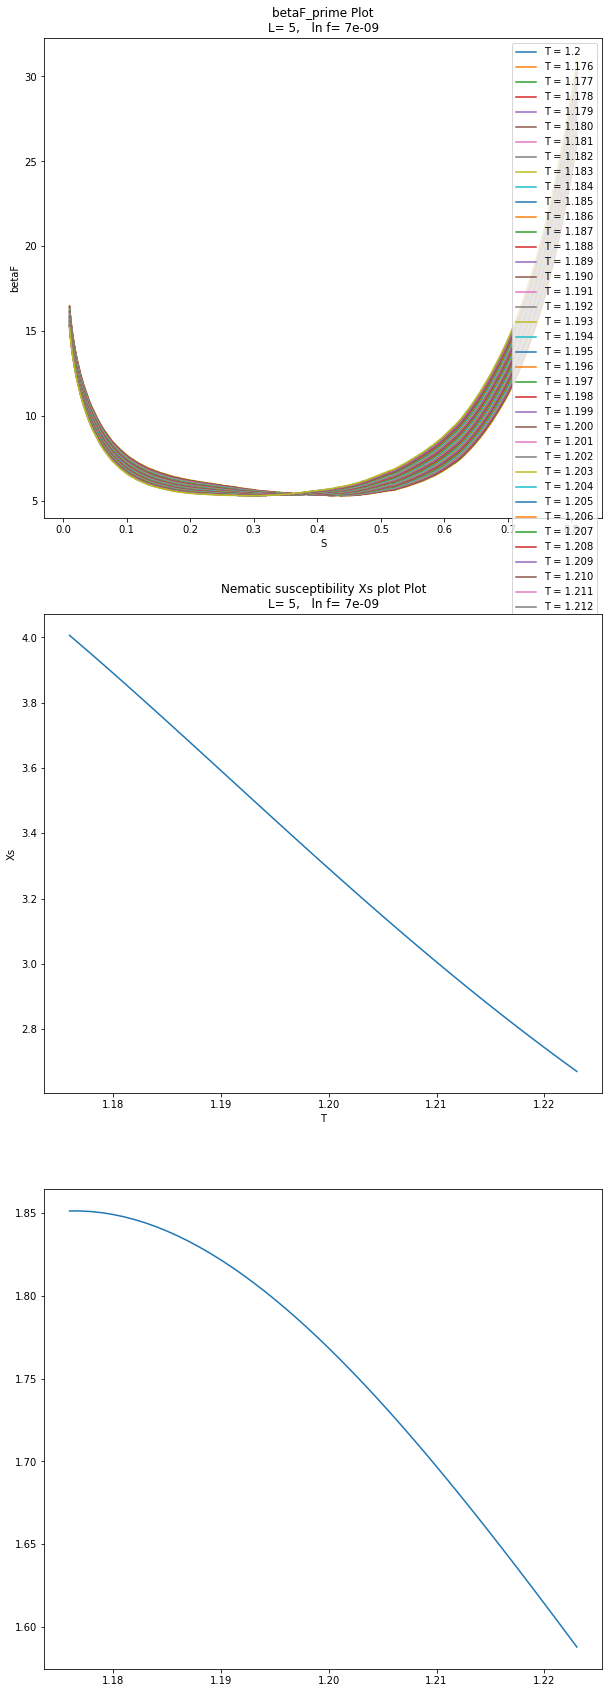

In [15]:
#BetaF & Omega plot

#Create an array for the S values
S_values = np.array([ S_min+step*i for i in range(N_bin_S) ])


#-- Calculation of the probability density -- ln(w(S,beta))
omega = np.array(omega)
#Make calculation easier
omega_norm = (omega[:] - min(omega[:])).copy()
#Normalizzation
omega_norm -= np.log(sum(np.exp(omega_norm)))


#-- betaF' --
#is the normalized version --> F'
betaF = -1*omega_norm


#-- reweighting --
rew_betaF, av_U, av_U_2, av_S, av_S_2 = rew_calc(ReW, ReU, ReU_2, Ns, S_values)
#Save to file
write_rew('rew_betaF', rew_betaF)


#-- Specific Heat --
Cv = np.zeros(len(betas))
for i in range(len(betas)):
    Cv[i] = ( (betas[i]**2)/(L**3) ) * ( av_U_2[i]-av_U[i]**2 )
    
#-- Nematic Susceptibility --
Xs = np.zeros(len(betas))
for i in range(len(betas)):
    Xs[i] = ( (L**3) * ( av_S_2[i]-av_S[i]**2 ) )
    
#Save to file thermodinamic proprieties
write_ThermoProp('ThProp', rew_Ts, Cv, Xs)


#-- PLOT --

#Inizialize sublot
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 30),nrows = 3, ncols = 1 )
#fig, (ax1, ax2) = plt.subplots(figsize=(20,10 ), nrows = 1, ncols = 2, gridspec_kw={'width_ratios': [1, 3]})
#fig, (ax1) = plt.subplots( nrows = 1, ncols = 1)

#Left Plot
ax1.plot(S_values[:], betaF[:], label= 'T = '+str(T))
for i in range(0,len(betas),1):
    ax1.plot(S_values[:], rew_betaF[i,:], label= 'T = ' + '{:.3f}'.format(rew_Ts[i]) )
ax1.set_title('betaF_prime Plot\n' + 'L= '+str(L) + ',   ' + 'ln f= ' + '{:.0e}'.format(ln_f))
ax1.set_xlabel('S')
ax1.set_ylabel('betaF')
ax1.legend()

#Center
ax2.plot(rew_Ts,Cv)
ax2.set_title('Specific heat Cv plot Plot\n' + 'L= '+str(L) + ',   ' + 'ln f= ' + '{:.0e}'.format(ln_f))
ax2.set_xlabel('T')
ax2.set_ylabel('Cv')


#Right
ax3.plot(rew_Ts,Xs)
ax2.set_title('Nematic susceptibility Xs plot Plot\n' + 'L= '+str(L) + ',   ' + 'ln f= ' + '{:.0e}'.format(ln_f))
ax2.set_xlabel('T')
ax2.set_ylabel('Xs')

# Cimitero di funzioni

In [ ]:
#Trial spin generation - EULER ANGLES

def spin_gen_Euler(old_spin, intensity):
    
    #Random EULER angle generation
    psi = ( 2 * np.pi * np.random.rand(1) ) * intensity
    phi = ( 2 * np.pi * np.random.rand(1) ) * intensity
    theta = ( 2 * np.pi * np.random.rand(1) ) * intensity
    
    #Populate the rotation matrix
    rot_mat = np.zeros((3,3))
    rot_mat[0,0] = np.cos(psi) * np.cos(phi) - np.cos(theta) * np.sin(phi) * np.sin(psi)
    rot_mat[0,1] = np.cos(psi) * np.sin(phi) + np.cos(theta) * np.cos(phi) * np.sin(psi)
    rot_mat[0,2] = np.sin(psi) * np.sin(theta)
  
    rot_mat[1,0] = - np.sin(psi) * np.cos(phi) - np.cos(theta) * np.sin(phi) * np.cos(phi)
    rot_mat[1,1] = - np.sin(psi) * np.sin(phi) + np.cos(theta) * np.cos(phi) * np.cos(psi)
    rot_mat[1,2] =  np.cos(psi) * np.sin(theta)
  
    rot_mat[2,0] =  np.sin(theta) * np.sin(phi)
    rot_mat[2,1] = - np.sin(theta) * np.cos(phi)
    rot_mat[2,2] =  np.cos(theta)
    
    #Apply rotation matrix
    new_spin = np.dot(rot_mat,old_spin)
    
    #Normalize to be sure
    new_spin /= np.linalg.norm(new_spin)
    
    return new_spin

#Update make_trial function
#Change a spin orientation in the lattice at random
#@jit(nopython=True)
def make_trial_Euler(input_system, intensity):
    '''outputs a new sistem ewual to the input for exeption of the orientation of one spin'''
    
    #extrapolate number of lattice points per axis.
    #  Cubic lattice has been assumed
    dim = input_system.shape[0]-2
    
    #clone input system into output system
    output_system = input_system.copy()
    
    #select a random spin in the lattice [low] ]high[
    #Random coord generation
    spin_index = [ np.random.randint(1,dim+1) for i in range(3)]
    #print(spin_index)
    
    #>>generate a randomly oriented spin
    new_spin = spin_gen_Euler(output_system[spin_index[0],spin_index[1],spin_index[2],:], intensity)
    
    #update the system with the new spin in the place of the corresponding old one
    output_system[spin_index[0],spin_index[1],spin_index[2],:] = new_spin[:].copy()
    
    #Update boundaries
    output_system = make_periodic_boundaries(output_system)
    
    
    return output_system, spin_index





#Change a spin orientation in the lattice at random
#@jit(nopython=True)
def make_trial(input_system):
    '''outputs a new sistem ewual to the input for exeption of the orientation of one spin'''
    
    #extrapolate number of lattice points per axis.
    #  Cubic lattice has been assumed
    dim = input_system.shape[0]-2
    
    #clone input system into output system
    output_system = input_system.copy()
    
    #select a random spin in the lattice [low] ]high[
    #Random coord generation
    spin_index = [ np.random.randint(1,dim+1) for i in range(3)]
    #print(spin_index)
    
    #generate a randomly oriented spin
    new_spin = spin_gen()
    
    #update the system with the new spin in the place of the corresponding old one
    output_system[spin_index[0],spin_index[1],spin_index[2],:] = new_spin[:]
    
    return output_system, spin_index



#Calculate the norm of each triplet of a matrix
@jit(nopython=True)
def mod_check(coords):
    '''Check if the coords of a spin gives norm = 1.'''
    
    magnitude = np.linalg.norm(coords)
    
    return magnitude


#Calculate Q  
@jit(nopython=True)
def calc_Q(input_system):
    '''Calculation of the tensor order parameter Q and its eigen(val/vect)
        
        > input_system = [i,j,k, spin_components = [x,y,z]]
        < [Q, [w, v]] : Q --> order parameter tensor
                        w --> list of eigenvalues
                        v --> list of eigenvectors
    '''
    
    # get the number of spins along x axis
    dim = np.shape(input_system)[0]-2
    
    # initialize the tensor Q with all 0s
    Q = np.zeros((3,3))
    
    #will act as a kroneker delta
    I = np.identity(3)
    
    for i in range(3):
        for j in range(3):

            #note: the factor 3 and the kroneker delta have been brought out the sum 
            Q[i,j] = (1/(2*dim**3)) * (3* np.sum( np.ravel(input_system[1:dim+1,1:dim+1,1:dim+1,i]*input_system[1:dim+1,1:dim+1,1:dim+1,j])  ) - I[i,j]*dim**3)
    
    #Calculation eigen(val&vect) of the order tensor Q
    #    [w = eigenvalues, v = eigenvectors]
    w, v = np.linalg.eig(Q)
    
    return Q , [w,v]



#Remove 0s from a list
#@jit(nopython=True)
def remove_0s(hist):

    #Clone hist in a new list
    hist_no_0 = hist.copy()
    
    n_zeros = hist_no_0.count(0)
    for i in range(n_zeros):
        hist_no_0.remove(0)
    
#    if n_zeros != 0:
#        print(n_zeros)
        
    return hist_no_0


#Evaluate flatness -- << Put an error check: (0/0) try <<
#@jit(nopython=True)
def flatness_calc_no0s(hist):
    
    #remove 0 from the histogram list
    hist_no_0 = remove_0s(hist)
    
    #note: if all 0 you can't make the division (0/0). Should make an error message
    flatness = 1 - (max(hist_no_0)-min(hist_no_0)) / (max(hist_no_0)+min(hist_no_0))
    
    return flatness

@jit(nopython=True)
def bin_boundary(min_val, max_val, N_bins):
    '''Create a list of couples of values of the type [[lowe_boundary,higher_boundary-eps], ...]
            > min_val --> minimum value that the variable (e.g. S) can reach
            > max_val --> maximum value that the variable (e.g. S) can reach
            > n_bins --> number of bins to be used to partition the interval (e.g. S)
            < boundaries --> list of the type [[lowe_boundary,higher_boundary-eps], ...]'''
    
    #bin width
    step = (max_val - min_val)/N_bins
    
    #evaluation of the bins upper and lower limit
    boundaries = [[ min_val + i*step , min_val + (i+1)*step - np.finfo(float).eps ] for i in range(N_bins)]
        
    #convert the list of list into an array
    boundaries = np.array(boundaries)
    
    #correct the last upper limit
    boundaries[N_bins-1][1] = max_val

    
    return boundaries



def bin_selection(S_val,boundaries_list):
    '''returns the index of the bin the number fit in
        > S_val --> value to be placed in a bin'''
    
    #count the number of bins
    N_bins = boundaries_list.shape[0]
    
    for i in range(N_bins):
        if (S_val >= boundaries_list[i,0] and S_val <= boundaries_list[i,1]):
            return i
    
    #if no bin was found, return this error value << Da gestire meglio <<
    return -1


@jit(nopython=True)
def bin_selection_v2(S_val,step,S_min):
    
    #extraction of the index
    bin_index = (S_val-S_min)/step
    bin_index =int(bin_index)
    
    #make also a control on S
    
    return bin_index



# Extra

In [3]:
#MC Simulation

@jit(nopython=True)
def debug_SuperFast_WL_Alg(N_bin_S ,omega_init_val ,ln_f ,ln_f_lim ,mul ,beta ,lim_flatness ,init_loops ,L ,flatness ,test ,cycle ,S_min ,S_max ):
    
    '''p represent the dictionary containing the imput parameters'''
    
    #Initialization internal param
    tot_cycles = N_MC_cycles(ln_f ,  ln_f_lim ,  mul )
    step = ( S_max  -  S_min ) /  N_bin_S 
    
    

    #initialization of bins 
    omega = [ omega_init_val  for i in range( N_bin_S )]
    
    #initialization of bins 
    hist = [0 for i in range( N_bin_S )]  
    
    #initializzation of the system
    old_system = system_gen( L , r = True)
    
    E_old = LL_energy_tot(old_system)
    
    #Calculate S
    S = calc_S(old_system)
    
    #Identifie the bin
    old_bin_index = bin_selection_v2(S, step, S_min)
    
    #Update hist
    hist[old_bin_index]= hist[old_bin_index] + 1
    #Update omega
    omega = update_omega(omega, old_bin_index, ln_f)



    cycle = 0
    while(ln_f >=  ln_f_lim ):


        flatness = 0.
        while(flatness <=  lim_flatness  ):
            for i in range( init_loops ):

                #ripeto il ciclo fino a che non accetto lo stato
                test = False
                while(test == False):
                    
                    #>generate a new trial system
                    #new_system, spin_index = make_trial(old_system)
                    new_system, spin_index = make_trial(old_system)

                    #Calculate S
                    S = calc_S(new_system)
                    
                    if S >= S_min and S <=  S_max :
                        

                        #Identifie the bin
                        new_bin_index = bin_selection_v2(S, step,S_min)


                        #decide if to accept the state
                        #>test, p = acc_test(old_system, 
                        test, E_old = acc_test(old_system, 
                                       new_system, 
                                       omega[old_bin_index], 
                                       omega[new_bin_index], 
                                       beta ,
                                       spin_index,
                                       E_old
                                      )



                print('ACCEPTED')
                #print('\n\n')

                #update systograms
                hist[new_bin_index] = hist[new_bin_index] + 1

                #print( p, new_bin_index )

                #Update omega
                omega = update_omega(omega, new_bin_index, ln_f)

                #Update variables
                old_system = new_system.copy()       
                old_bin_index = new_bin_index

                #print(i)

            #calculate flatnes                
            flatness = flatness_calc(hist)


        # note: we are dealing with ln(f)
        ln_f = ln_f *  mul 

        #cycle counter
        cycle += 1 

        #display state
        print('state: ', cycle, '/', tot_cycles )
        
        #reset hystogram entries
        hist = [0 for i in range( N_bin_S )]

    
    
    
    print('\n\n-----------------------------------')
    print('ln_f: ', ln_f)
    
    #return {'omega':omega, 'hist':hist, 'ln_f':ln_f}
    #a = [omega,hist,ln_f]

    
    
    
    return omega, hist, ln_f

In [2]:
#MC Simulation

@jit(nopython=True)
def SuperFast_WL_Alg(N_bin_S ,omega_init_val ,ln_f ,ln_f_lim ,mul ,beta ,lim_flatness ,init_loops ,L ,flatness ,test ,cycle ,S_min ,S_max ):
    
    '''p represent the dictionary containing the imput parameters'''
    
    #Initialization internal param
    tot_cycles = N_MC_cycles(ln_f ,  ln_f_lim ,  mul )
    step = ( S_max  -  S_min ) /  N_bin_S 
    
    

    #initialization of bins 
    omega = [ omega_init_val  for i in range( N_bin_S )]
    
    #initialization of bins 
    hist = [0 for i in range( N_bin_S )]  
    
    #initializzation of the system
    old_system = system_gen( L , r = True)
    
    E_old = LL_energy_tot(old_system)
    
    #Calculate S
    S = calc_S(old_system)
    
    #Identifie the bin
    old_bin_index = bin_selection_v2(S, step, S_min)
    
    #Update hist
    hist[old_bin_index]= hist[old_bin_index] + 1
    #Update omega
    omega = update_omega(omega, old_bin_index, ln_f)
    
    #print(omega)


    cycle = 0
    while(ln_f >=  ln_f_lim ):


        flatness = 0.
        while(flatness <=  lim_flatness  ):
            for i in range( init_loops ):

                #ripeto il ciclo fino a che non accetto lo stato
                test = False
                while(test == False):

                    #generate a new trial system
                    new_system, spin_index = make_trial(old_system)
                    
                    #Calculate S
                    S = calc_S(new_system)

                    if S >= S_min and S <=  S_max :

                        #Identifie the bin
                        new_bin_index = bin_selection_v2(S, step,S_min)


                        #decide if to accept the state
                        #test, p = acc_test(old_system, 
                        test, E_old = acc_test(old_system, 
                                       new_system, 
                                       omega[old_bin_index], 
                                       omega[new_bin_index], 
                                       beta ,
                                       spin_index,
                                       E_old
                                      )



                #print('ACCEPTED')
                #print('\n\n')

                #update systograms
                hist[new_bin_index] = hist[new_bin_index] + 1

                #print( p, new_bin_index )

                #Update omega
                omega = update_omega(omega, new_bin_index, ln_f)

                #Update variables
                old_system = new_system.copy()       
                old_bin_index = new_bin_index

                #print(i)

            #calculate flatnes                
            flatness = flatness_calc(hist)
            #print(flatness, 'hist: ', hist)


        # note: we are dealing with ln(f)
        ln_f = ln_f *  mul 

        #cycle counter
        cycle += 1 

        #display state
        print('state: ', cycle, '/', tot_cycles )
        
        #reset hystogram entries
        hist = [0 for i in range( N_bin_S )]

    
    
    
    print('\n\n-----------------------------------')
    print('ln_f: ', ln_f)
    
    #return {'omega':omega, 'hist':hist, 'ln_f':ln_f}
    #a = [omega,hist,ln_f]

    
    
    
    return omega, hist, ln_f

# Metodi per generare uno spin

In [ ]:
def Sbagliato_2_spin_gen():
    
    '''Genero direttamenti le componenti'''
    
    spin_coord = np.random.rand(3)*2-1
    spin_coord = spin_coord[:]/np.linalg.norm(spin_coord)
    
    return spin_coord


@jit(nopython=True)
def Sbagliato_spin_gen():
    '''Generate a set of coords. [x,y,z] for 1 randomly oriented spin'''
    
    #Angele with the z axis. 
    #  for spin up you have theta = 0
    theta = np.random.uniform(0,np.pi)
    #Angle on the xy plane.
    #  For spin along x you have phi = 0
    phi = np.random.uniform(0,np.pi)

    #Calculate the [x,y,z] components from [r=1,theta,phi]
    x = np.sin(theta)* np.cos(phi) 
    y = np.sin(theta)* np.sin(phi) 
    z = np.cos(theta)

    #> DeBug <
    #val = np.linalg.norm([x,y,z])
    #print(x,y,z, val)
       
    return [x,y,z]

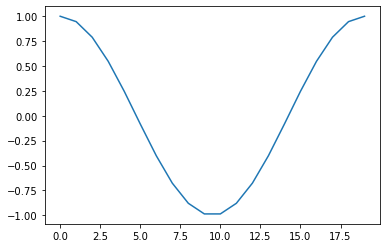

In [16]:
a = [np.cos((2*np.pi)*i/19) for i in range(20)]
plt.plot(a)

# Studio generazione numeri random

[-0.36946981290746983, 0.22875021887441915, 0.9006472087976647]
0.9999999999999998


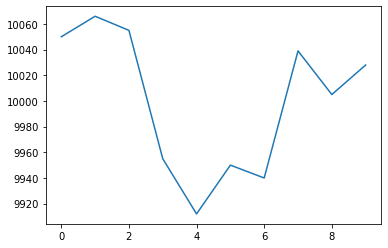

In [186]:
#studio sulla generatione dei numeri random

a = spin_gen()
print(a)
norm = np.linalg.norm(a)
print(norm)
N = 100000
#g=[debug_spin_gen() for i in range(N)]
#g=[Sbagliato_spin_gen() for i in range(N)]
g=[spin_gen() for i in range(N)]
f= [abs(a[0]) for a in g]

div = 10
delta = 1./10.
hist = np.zeros(div)
for i in range(N):
    ind = int(f[i]/delta)
    hist[ind] += 1
plt.plot(hist)

# -------------------------------------------------------------------------------------------------------------

# Test con angoli di Euero e non

Studio la distribuzione di S usando spin gen Eulero e spin gen no Eulero

In [377]:
#Con EULERO
S_min = 0.
S_max = 1.1
N_bins  = 10
loops = 2000000
dim = 5
intensity = 0.05


step = (S_max-S_min)/N_bins

hist = [0 for i in range( N_bins )] 
old_system = system_gen( dim , r = False)
S = calc_S(old_system)
new_bin_index = bin_selection_v2(S, step,S_min)
hist[new_bin_index] += 1

for i in range(loops):
    #> here is the change
    new_system, spin_index = make_trial_Euler(old_system, intensity)
    
    S = calc_S(new_system)
    new_bin_index = bin_selection_v2(S, step,S_min)
    hist[new_bin_index] += 1
    old_system = new_system.copy()

x = [step*i for i in range(N_bins)]    
plt.plot(x,hist)
print(hist)

KeyboardInterrupt: 

In [ ]:
#No EULERO
S_min = 0.
S_max = 1.
N_bins  = 10
loops = 2000000
dim = 5
intensity = 0.05


step = (S_max-S_min)/N_bins

hist = [0 for i in range( N_bins )] 
old_system = system_gen( dim , r = True)
S = calc_S(old_system)
new_bin_index = bin_selection_v2(S, step,S_min)
hist[new_bin_index] += 1

for i in range(loops):
    new_system, spin_index = make_trial(old_system)
    S = calc_S(new_system)
    new_bin_index = bin_selection_v2(S, step,S_min)
    hist[new_bin_index] += 1
    old_system = new_system.copy()

x = [step*i for i in range(N_bins)]    
plt.plot(x,hist)
print(hist)

In [ ]:
#explore S distribution
loop = 200000000

S_min = 0.
S_max = 1.0001
Bins_number = 10


#bin preparation
step = (S_max-S_min)/Bins_number

cont = [0 for i in range(Bins_number)]

sys = system_gen( 2 , r = True)
#Calculate S
S = calc_S(sys)
index = bin_selection_v2(S, step, S_min) 
cont[index] += 1
    
for i in range(loop):

    #generate a new trial system
    new_system, index = make_trial(sys)
                
    #Calculate S
    S = calc_S(new_system)
    
    sys = new_system.copy()
    
    index = bin_selection_v2(S, step, S_min) 
    cont[index] += 1

x= [i*step for i in range(Bins_number)]
plt.plot(x,cont)
print(S)
print(cont)

# ------------------------------------------------------------------------------------------------

# Altri test

In [172]:
# >> .copy()  <<

#tets , cos asuccede se non faccio.copy()
# se stai cambiando roba interna allora non si aggiorna utomaticamente
# tuttavia se fai una copia con slicing allora, quando modifichi uno si modifica anche l'altro
# funziona anche se estraggo una sottomatrice

a = np.array([[1,2,3,4], [0,0,0,0]])
b   = a[:,2:]
a[1,:] = a[0,:]
print(a)
print(b)
a[0,:] = 0
print(a)
print(b)

[[1 2 3 4]
 [1 2 3 4]]
[[3 4]
 [3 4]]
[[0 0 0 0]
 [1 2 3 4]]
[[0 0]
 [3 4]]


In [ ]:
#Studio condizioni periodiche

N = 4
a = np.array([[[0 for i in range(-1,N+1)]for j in range (-1,N+1) ]for k in range(-1,N+1)])
b = np.array([[[k+1 for i in range(-1,N+1)]for j in range (-1,N+1) ]for k in range(-1,N+1)])

a[0,:,:] = b[N,:,:]
a[N+1,:,:] = b[1,:,:]
a[:,0,:] = b[:,N,:]
a[:,N+1,:] = b[:,1,:]
a[:,:,0] = b[:,:,N]
a[:,:,N+1] = b[:,:,1]
print(a)

In [ ]:
old_system = system_gen( L , r = True)
make_trial(old_system)